# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Задача

Обучить модели предсказывающие рыночную стоимость автомобиля. Выбрать лучшую из них руководствуясь метрикой RMSE и её быстродействием.

# Описание данных

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)

# Импорт библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

import scipy.stats as stats

import time

import seaborn as sns

# Подготовка данных

In [2]:
df = pd.read_csv('autos.csv')

Для начала, основываясь на описаниях, поразмыслим над тем, какие из столбцов вообще пригодятся. Из представленных в таблице сомнительными кажутся: DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen.

DateCrawled, DateCreated и LastSeen - это даты создания записей и прочие даты, являющиеся внутренней информацией сервиса, и с автомобилями напрямую не связанные. А значит они не нужны для построения модели.

RegistrationMonth - месяц регистрации автомобиля далеко не так важен как год. Сомнительно, что для модели это будет ценный параметр.

NumberOfPictures, PostalCode - напрямую с автомобилем не связаны. Для построения модели не нужны.

Все эти 6 столбцов можно удалить из датафрейма.

In [3]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth', 'NumberOfPictures'], axis=1)

**Корреляции**


			 PEARSON


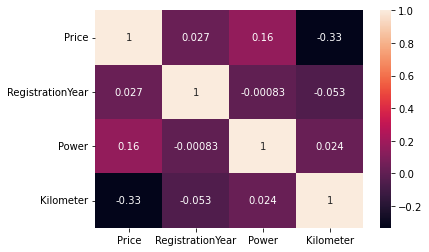


			 KENDALL


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


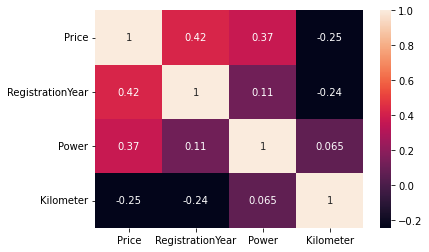


			 SPEARMAN


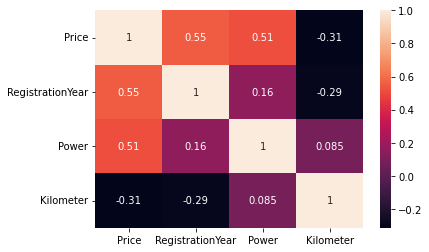

In [4]:
for _ in ['pearson', 'kendall', 'spearman']:
    print('\n\t\t\t', _.upper())
    sns.heatmap(df.corr(method=_), annot=True)
    plt.show()

Слабые корреляции наблюдаются при оценке ранговой корреляцией Спирмана между ценой и годом регистрации/ мощностью автомобиля.

---

Теперь можно взгянуть на датафрейм.

In [5]:
print(df.info())
display(df.describe(include='all').transpose())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,354369,40,volkswagen,77013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NotRepaired,283215,2,no,247161,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


Взглянем на столбцы с откровенно странными значениями.

## RegistrationYear

Минимальное значение 1000, максимальное 9999. Чтобы это исправить ограничим допустимый временной интервал для даты регистрации авто. Теперь он будет с 1980 по 2022 год.

In [6]:
df = df.query('1980 <= RegistrationYear <=2022')
df.sort_values('RegistrationYear')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
310531,1,NaN,1980,auto,0,other,5000,NaN,mercedes_benz,NaN
308884,690,NaN,1980,NaN,0,NaN,150000,NaN,mercedes_benz,NaN
74037,2600,NaN,1980,NaN,34,kaefer,150000,petrol,volkswagen,NaN
74222,20,NaN,1980,NaN,0,other,5000,NaN,opel,NaN
104349,400,NaN,1980,NaN,0,NaN,100000,petrol,skoda,NaN
...,...,...,...,...,...,...,...,...,...,...
101989,1800,NaN,2019,manual,122,c_klasse,150000,petrol,mercedes_benz,no
332451,0,NaN,2019,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
48562,0,NaN,2019,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
209501,100,NaN,2019,manual,125,cr_reihe,20000,NaN,honda,no


Не смотря на то, что год регистрации по сути является категориальным признаком, он будет трактоваться как числовой. Так как зависимость между годом регистрации и ценой автомобиля в общем случае прямая. Чем новее автомобиль, тем он дороже.

## Price

Поскольку это сервис продажи, а не дарения автомобилей, то автомобили с совсем уж символическими ценами нужно убрать. Символической будем считать цену до 100 евро.

In [7]:
df = df.query('Price >= 100')
df.sort_values('Price')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
100389,100,small,1997,manual,65,corsa,150000,petrol,opel,yes
267285,100,small,1997,manual,0,NaN,150000,petrol,renault,no
122685,100,NaN,2000,NaN,0,NaN,150000,NaN,volkswagen,NaN
267251,100,small,1997,manual,75,other,80000,petrol,citroen,NaN
10185,100,NaN,2005,NaN,0,ka,150000,NaN,ford,yes
...,...,...,...,...,...,...,...,...,...,...
6863,20000,coupe,2002,NaN,0,NaN,30000,NaN,sonstige_autos,yes
58087,20000,sedan,2012,auto,143,1er,60000,gasoline,bmw,no
101793,20000,coupe,2007,auto,272,3er,100000,petrol,bmw,no
77531,20000,sedan,1998,auto,306,c_klasse,80000,petrol,mercedes_benz,no


## Power

Столбец Power принимает очень странные значения, взглянем на него.

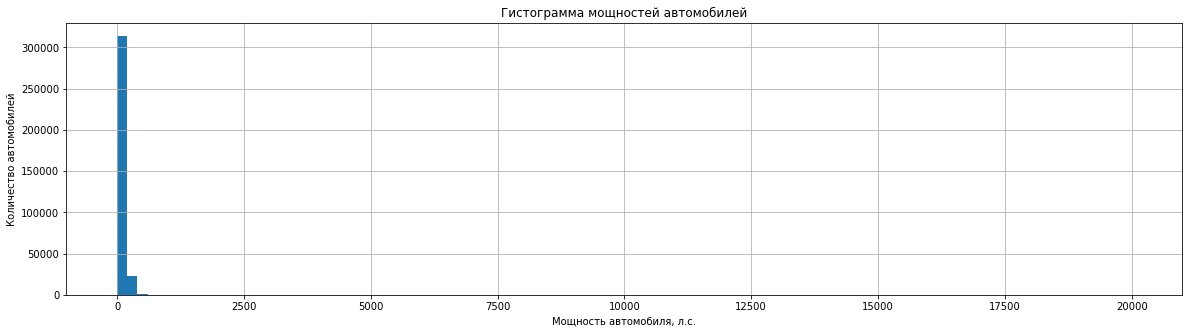

In [8]:
df['Power'].hist(bins=100, figsize=(20, 5))
plt.title('Гистограмма мощностей автомобилей')
plt.xlabel('Мощность автомобиля, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

Очевидно наличие некоторого количества эктсремально больших значений. Сострижем 1 % самых больших значений по признаку Power.

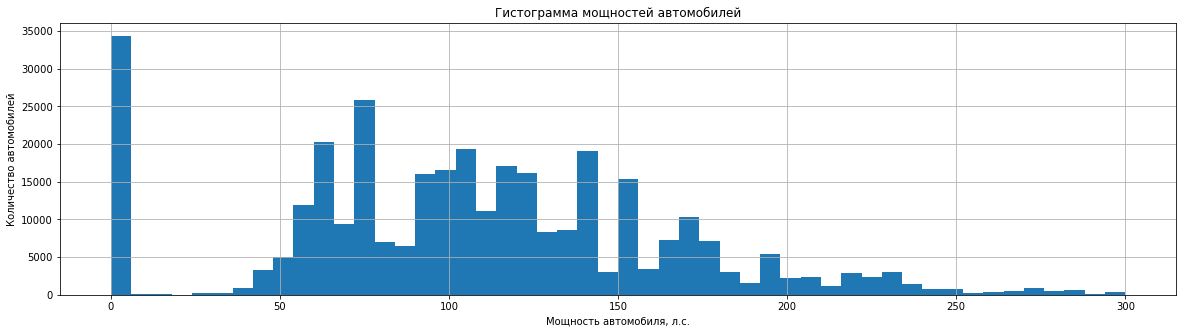

In [9]:
upper = df['Power'].quantile(0.99)
df = df.query('Power <= @upper')
df['Power'].hist(bins=50, figsize=(20, 5))
plt.title('Гистограмма мощностей автомобилей')
plt.xlabel('Мощность автомобиля, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

Видно, что присутсвует множество автомобилей с нулевым или близким к нулю количеством лошадиных сил. Можно предположить, что машины с 0 л.с. это машины не на ходу. И по-хорошему их бы стоило отделить от основной массы машин и сделать для них отдельное предсказание. Чем займемся чуть позже.

Пока что разделим автомобили на 2 группы: те что на ходу и те что не на ходу. Из тех что на ходу срежем 1 % наименьших значений по признаку Power.

In [10]:
df_broken = df.query('Power == 0')
lower = df.query('Power != 0')['Power'].quantile(0.01)
df = df.query('Power >= @lower')

Можно проверить обсонованность такого разделения сравнив гистограммы плотности распределения для цен.

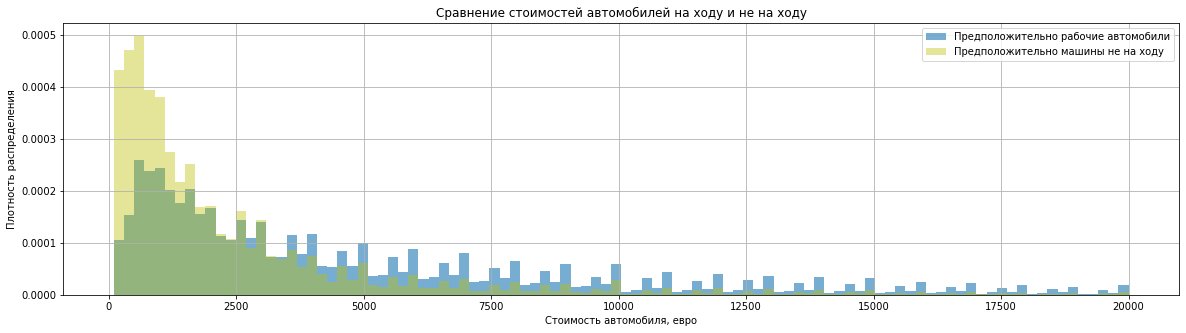

Средняя стоимость автомобиля на ходу = 4754.490289032457 евро, средняя стоимость автомобиля не на ходу = 2399.274319180088 евро.


In [11]:
ax = df.plot(kind='hist', alpha=0.6, y='Price', label='Предположительно рабочие автомобили', bins=100, density=True)
(
    df_broken.plot(kind='hist', alpha=0.4, y='Price', label='Предположительно машины не на ходу', bins=100, density=True,
                            grid=True, title='Сравнение стоимостей автомобилей на ходу и не на ходу', color='y', ax=ax, figsize=(20, 5))
)
plt.ylabel('Плотность распределения')
plt.xlabel('Стоимость автомобиля, евро')
plt.show()
print(f'Средняя стоимость автомобиля на ходу = {df.Price.mean()} евро, средняя стоимость автомобиля не на ходу = {df_broken.Price.mean()} евро.')

Действительно видно, что среди автомобилей с мощностью двигателя в 0 л.с. цены в среднем значительно ниже чем у автомобилей, которые способны самостоятельно передвигаться.

Однако, также можно заметить, что длинный хвост из значений дорогих автомобилей присутсвует как у движимых, так и у недвижимых авто. И если в случае с движимыми это вполне объяснимо, то в случае недвижимых это довольно сомнительно. Поэтому от недвижимых необходимо обрезать хвост самых доргих авто длиной в 5 %. 

In [12]:
upper = df_broken['Price'].quantile(0.95)
df_broken = df_broken.query('Price <= @upper')

Но поскольку предварительная обработка еще не закончена, то вновь объединим эти группы.

In [13]:
df = pd.concat([df_broken, df])

Взглянем на то что получилось.

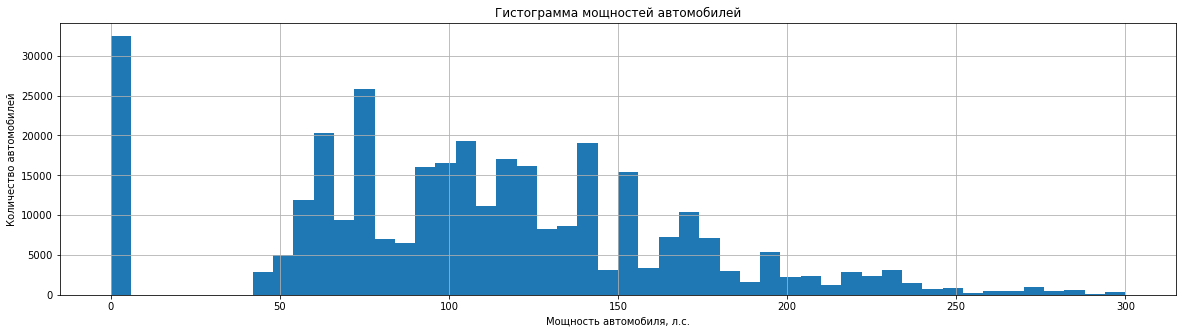

In [14]:
df['Power'].hist(bins=50, figsize=(20, 5))
plt.title('Гистограмма мощностей автомобилей')
plt.xlabel('Мощность автомобиля, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

## Остаточная обработка

Оставшиеся пропуски заполнить не представляется возможным. Придется их удалить.

In [15]:
df = df.dropna()

И заменим yes, no на True, False в колонке NotRepaired.

In [16]:
df = df.replace({'yes' : True, 'no' : False})

И удалим дупликаты.

In [17]:
df = df.drop_duplicates()

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200954 entries, 55 to 354367
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             200954 non-null  int64 
 1   VehicleType       200954 non-null  object
 2   RegistrationYear  200954 non-null  int64 
 3   Gearbox           200954 non-null  object
 4   Power             200954 non-null  int64 
 5   Model             200954 non-null  object
 6   Kilometer         200954 non-null  int64 
 7   FuelType          200954 non-null  object
 8   Brand             200954 non-null  object
 9   NotRepaired       200954 non-null  bool  
dtypes: bool(1), int64(4), object(5)
memory usage: 15.5+ MB
None


# Обучение моделей

Для начала разделим датафрейм сначала на автомобили по их мощности, а затем на признаки и целевой признак.

In [19]:
df_broken = df.query('Power == 0').drop('Power', axis=1)
X_broken = df_broken.drop('Price', axis=1)
y_broken = df_broken.Price
df = df.query('Power != 0')
X = df.drop('Price', axis=1)
y = df.Price

Разделим датафреймы на обучающую и тестовую выборки. Предварительно преобразуем категориальные признаки с помощью техники OHE.

In [20]:
categorical_data = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
transformer = ColumnTransformer(
    [('OHE', OneHotEncoder(drop='first'), categorical_data)],
    remainder='passthrough'
)
X_broken = transformer.fit_transform(X_broken)
X = transformer.fit_transform(X)

In [21]:
X_broken_train, X_broken_test, y_broken_train, y_broken_test = train_test_split(X_broken, y_broken, test_size=0.2, random_state=24)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

Зададим модели и границы для перебора их параметров, для проведения дальнейшего RandomizedSearchCV.

In [22]:
models_params = {
    ElasticNet(random_state=24) : dict(alpha=stats.uniform(0, 1), l1_ratio=stats.uniform(0, 1)),
    DecisionTreeRegressor(random_state=24) : dict(max_depth=range(1, 101), min_samples_split=stats.loguniform(1e-5, 1e-2)),
    LGBMRegressor(random_state=24) : dict(max_depth=range(-1, 201), num_leaves=range(5, 101), n_estimators=range(1, 201)),
    DummyRegressor() : dict(strategy=['mean'])
}

In [23]:
trained_models=[]
for model, params in models_params.items():
    timer = time.time()
    random_search = RandomizedSearchCV(model, param_distributions=params, scoring='neg_root_mean_squared_error', random_state=24, n_iter=50, cv=5)
    random_search.fit(X_train, y_train)
    timer = time.time() - timer
    print(f'Обучение модели {model} заняло {timer:.2f} сек или {(timer / 60):.2f} мин')
    trained_models.append(random_search)

Обучение модели ElasticNet(random_state=24) заняло 362.53 сек или 6.04 мин
Обучение модели DecisionTreeRegressor(random_state=24) заняло 1259.16 сек или 20.99 мин
Обучение модели LGBMRegressor(random_state=24) заняло 154.74 сек или 2.58 мин
Обучение модели DummyRegressor() заняло 0.08 сек или 0.00 мин


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Построим аналогичные модели для автомобилей не на ходу.

In [24]:
trained_models_broken=[]
for model, params in models_params.items():
    timer = time.time()
    random_search = RandomizedSearchCV(model, param_distributions=params, scoring='neg_root_mean_squared_error', random_state=24, n_iter=100, cv=5)
    random_search.fit(X_broken_train, y_broken_train)
    timer = time.time() - timer
    print(f'Обучение модели {model} заняло {timer:.2f} сек или {(timer / 60):.2f} мин')
    trained_models_broken.append(random_search)

Обучение модели ElasticNet(random_state=24) заняло 18.01 сек или 0.30 мин
Обучение модели DecisionTreeRegressor(random_state=24) заняло 44.50 сек или 0.74 мин
Обучение модели LGBMRegressor(random_state=24) заняло 45.72 сек или 0.76 мин
Обучение модели DummyRegressor() заняло 0.01 сек или 0.00 мин


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# Анализ моделей

In [25]:
def model_scoring(model, X_test, y_test): # функция для выведения оценки модели.
    print('Модель', model.best_estimator_)
    print('Лучший RMSE при кросс-валидации =', -model.best_score_)
    timer = time.time()
    predicted = model.predict(X_test)
    timer = time.time() - timer
    print(f'Предсказание заняло {timer:.2f} сек или {(timer * 1000):.2f} мс')
    print(f'RMSE на тестовой выборке = {mean_squared_error(y_test, predicted, squared=False)}')
    print('\n***\n')
    return None

Модели для автомобилей на ходу.

In [26]:
for model in trained_models:
    model_scoring(model, X_test, y_test)

Модель ElasticNet(alpha=0.7367514493829402, l1_ratio=0.9954506743662491,
           random_state=24)
Лучший RMSE при кросс-валидации = 2440.637244313755
Предсказание заняло 0.00 сек или 1.00 мс
RMSE на тестовой выборке = 2452.937397669664

***

Модель DecisionTreeRegressor(max_depth=48, min_samples_split=0.00034427533919546084,
                      random_state=24)
Лучший RMSE при кросс-валидации = 1738.0349804805162
Предсказание заняло 0.01 сек или 9.99 мс
RMSE на тестовой выборке = 1707.2778365738397

***

Модель LGBMRegressor(max_depth=125, n_estimators=198, num_leaves=92, random_state=24)
Лучший RMSE при кросс-валидации = 1526.666170423034
Предсказание заняло 0.31 сек или 311.99 мс
RMSE на тестовой выборке = 1525.2496809889467

***

Модель DummyRegressor()
Лучший RMSE при кросс-валидации = 4733.713841276241
Предсказание заняло 0.00 сек или 1.00 мс
RMSE на тестовой выборке = 4721.706741590627

***



**Вывод по моделям для автомобилей на ходу:**

Наилучшую метрику RMSE из всех проверенных моделей показала модель из библиотеки lightgbm под названием LGBMRegressor. Также она обучилась быстрее прочих моделей.

Качество модели DummyRegressor ниже чем у других моделей. Проверка на адекватность моделей пройдена.

---
Модели для автомобилей не на ходу.

In [27]:
for model in trained_models_broken:
    model_scoring(model, X_broken_test, y_broken_test)

Модель ElasticNet(alpha=0.7367514493829402, l1_ratio=0.9954506743662491,
           random_state=24)
Лучший RMSE при кросс-валидации = 1308.0677137287328
Предсказание заняло 0.00 сек или 1.00 мс
RMSE на тестовой выборке = 1308.9827137130992

***

Модель DecisionTreeRegressor(max_depth=88, min_samples_split=0.009990837099723605,
                      random_state=24)
Лучший RMSE при кросс-валидации = 1229.3106937717596
Предсказание заняло 0.00 сек или 1.00 мс
RMSE на тестовой выборке = 1239.1286677209657

***

Модель LGBMRegressor(max_depth=128, n_estimators=90, num_leaves=42, random_state=24)
Лучший RMSE при кросс-валидации = 1063.289184040967
Предсказание заняло 0.01 сек или 8.01 мс
RMSE на тестовой выборке = 1029.8493896242444

***

Модель DummyRegressor()
Лучший RMSE при кросс-валидации = 1937.0957701876803
Предсказание заняло 0.00 сек или 0.00 мс
RMSE на тестовой выборке = 1900.6048566292206

***



**Вывод по моделям для автомобилей не на ходу:**

Качество LGBMRegressor вновь оказалось лучшим среди других моделей. Однако обучение на выборке меньшего размера заняло больше времени для данной модели.

Качество модели DummyRegressor ниже чем у других моделей. Проверка на адекватность моделей пройдена.

# Вывод 

В исследовании были построены модели для предсказания стоимости атомобилей. Причем для предсказания стоимости автомобилей на ходу были построены иные модели, чем для автомобилей не на ходу.

В обоих случаях наилучший результат среди других моделей показала модель LGBMRegressor. Кроме того данная модель имела более высокую скорость обучения по сравнению с другими моделями при обучении на большем объеме данных. Однако, при обучении на значительно меньшей выборке данная модель была довольно медлительна по сравнению с другими. Что хоть и любопытно, но не столь критично, так как на малых выборках скорость обучения в принципе намного больше чем на больших.

Модель DecisionTreeRegressor показала второй по качеству результат. Однако обучалась она довольно долго.

Наихудший результат с точки зрения качества предсказания показала линейная регрессия ElasticNet. Но при этом скорость обучения была довольно высока. Что и ожидалось от линейной регрессии.